## Train Normal Darcy

In [30]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import DarcyDataset
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from torch.utils.data import DataLoader

import sys
import os
import os
base_dir = 'e:/UCLCS/UCL Project/Neural Operator/COMP0031-Model-Compression-on-Neural-Operator'
dataset_dir = os.path.join(base_dir, 'Datasets', 'darcy_32')
root_dir = dataset_dir

device = 'cuda'

In [15]:
darcy_dataset = DarcyDataset(
    root_dir=dataset_dir,
    n_train=1000, batch_size=32,
    test_resolutions=[16, 32], n_tests=[100, 50],
    test_batch_sizes=[32, 32],
    train_resolution=32,
)

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 


C:\Users\Evave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\neuralop\data\datasets\pt_dataset.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub fo

In [33]:
train_db, test_dbs, data_processor = darcy_dataset.train_db, darcy_dataset.test_dbs, darcy_dataset.data_processor
train_loader = DataLoader(train_db, batch_size=32, shuffle=True)
test_loaders = {16: DataLoader(test_dbs[16], batch_size=32, shuffle=True), 32: DataLoader(test_dbs[32], batch_size=32, shuffle=True)}

In [34]:
print(train_loader)
print(test_loaders)

{16: <torch.utils.data.dataloader.DataLoader object at 0x0000014D7E786E10>, 32: <torch.utils.data.dataloader.DataLoader object at 0x0000014D7E633390>}


In [35]:
model = FNO(n_modes=(16, 16),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [36]:
optimizer = AdamW(model.parameters(),
                                lr=8e-3,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [37]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [38]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [39]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Raw outputs of shape torch.Size([32, 1, 32, 32])
[0] time=1.37, avg_loss=0.6673, train_err=20.8528
Eval: 16_h1=0.4429, 16_l2=0.2822, 32_h1=0.4395, 32_l2=0.2713
[3] time=0.33, avg_loss=0.2058, train_err=6.4326
Eval: 16_h1=0.2623, 16_l2=0.1765, 32_h1=0.2021, 32_l2=0.1525
[6] time=0.34, avg_loss=0.1543, train_err=4.8225
Eval: 16_h1=0.2583, 16_l2=0.1683, 32_h1=0.1776, 32_l2=0.1318
[9] time=0.34, avg_loss=0.1293, train_err=4.0392
Eval: 16_h1=0.2360, 16_l2=0.1406, 32_h1=0.1466, 32_l2=0.0994
[12] time=0.38, avg_loss=0.1081, train_err=3.3779
Eval: 16_h1=0.2382, 16_l2=0.1386, 32_h1=0.1522, 32_l2=0.0996
[15] time=0.36, avg_loss=0.0980, train_err=3.0633
Eval: 16_h1=0.2410, 16_l2=0.1363, 32_h1=0.1455, 32_l2=0.0881
[18] time=0.35, avg_loss=0.0884, train_err=2.7628
Eval: 16_h1=0.2314, 16_l2=0.1243, 32_h1=0.1315, 32_l2=0.0744


{'train_err': 2.6938803773373365,
 'avg_loss': 0.08620417207479476,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.33181810000678524}

In [42]:
torch.save(model, r"E:\UCLCS\UCL Project\Neural Operator\COMP0031-Model-Compression-on-Neural-Operator\models\darcy.pth")

C:\Users\Evave\AppData\Local\Temp\ipykernel_6532\2680554711.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


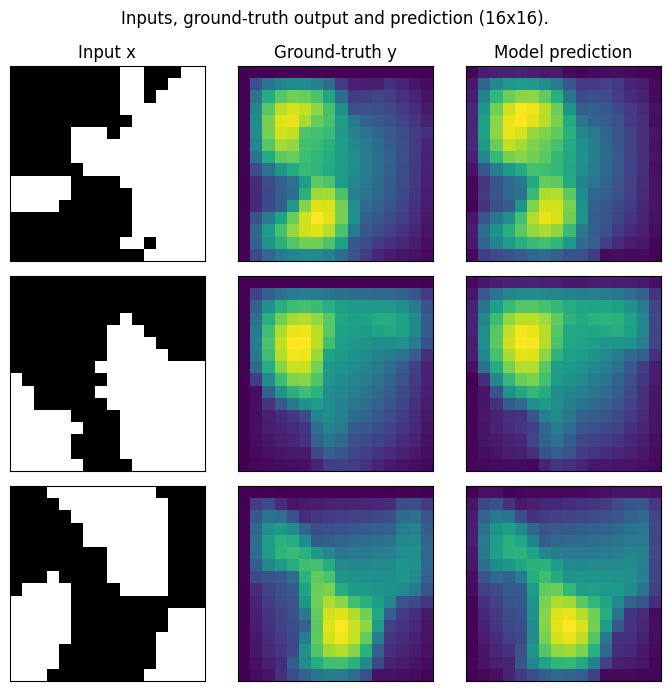

In [40]:
test_samples = test_loaders[16].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.cpu().squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()

C:\Users\Evave\AppData\Local\Temp\ipykernel_6532\1530896810.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


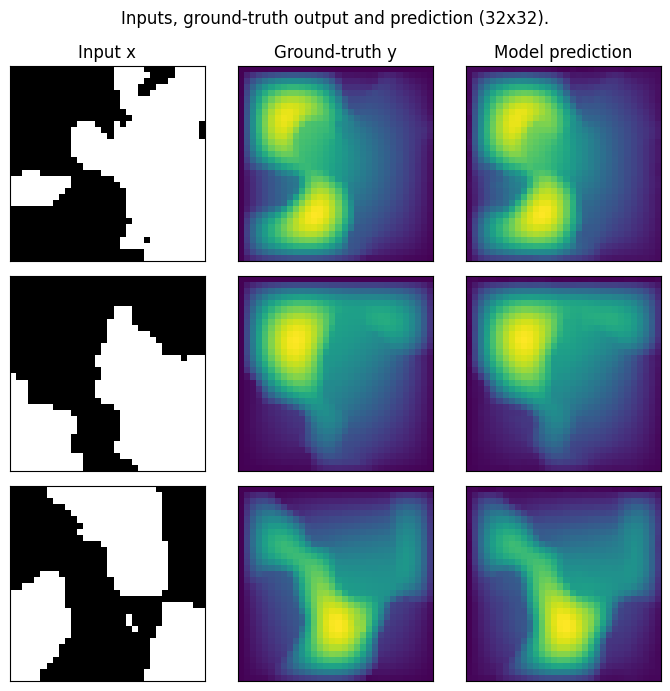

In [41]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.cpu().squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (32x32).', y=0.98)
plt.tight_layout()
fig.show()